In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

sns.set_style('whitegrid', {'axes.grid' : False})
%matplotlib inline

In [0]:
# Mounting the drive in google colab account. 
import os
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Path to data in the drive
path_to_data = 'drive/My Drive/Colab Notebooks'
os.listdir(path_to_data)

In [0]:
# Loading tidy datasets with features and target for machine learning models.
data = pd.read_csv(os.path.join(path_to_data, 'protein_cls.csv'), index_col=0)

In [0]:
data.head()

,structureId,classification,experimentalTechnique,residueCount,resolution,structureMolecularWeight,densityMatthews,densityPercentSol,phValue,sequence,label,lengths
0,101M,oxygen transport,X-RAY DIFFRACTION,154,2.07,18112.80,3.09,60.20,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,48,154
1,102L,hydrolase/o-glycosyl,X-RAY DIFFRACTION,165,1.74,18926.61,2.75,55.28,9.0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,63,165
2,102M,oxygen transport,X-RAY DIFFRACTION,154,1.84,18010.64,3.09,60.20,9.0,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,48,154
3,103L,hydrolase/o-glycosyl,X-RAY DIFFRACTION,167,1.90,19092.72,2.70,54.46,9.0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,63,167
4,104L,hydrolase/o-glycosyl,X-RAY DIFFRACTION,332,2.80,37541.04,3.04,59.49,9.0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSAA...,63,166


In [0]:
data = data.dropna().reset_index().drop(columns='index', axis=1)

In [0]:
data.isnull().sum()

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86877 entries, 0 to 86876
Data columns (total 12 columns):
structureId                 86877 non-null object
classification              86877 non-null object
experimentalTechnique       86877 non-null object
residueCount                86877 non-null int64
resolution                  86877 non-null float64
structureMolecularWeight    86877 non-null float64
densityMatthews             86877 non-null float64
densityPercentSol           86877 non-null float64
phValue                     86877 non-null float64
sequence                    86877 non-null object
label                       86877 non-null int64
lengths                     86877 non-null int64
dtypes: float64(5), int64(3), object(4)
memory usage: 8.0+ MB


In [0]:
# Plotting the pair distrihution among the features. 
plt.rcParams['font.size'] = 12
sns.pairplot(data)
plt.show()

In [0]:
# Distribution of sequences as Ph-values
def set_phlevel(x):
    if x > 7:
        return 'Basic'
    elif x < 7:
        return 'Acidic'
    else:
        return 'Neutral'

data['ph_level'] = data['phValue'].apply(set_phlevel)
ph_level = data.groupby('ph_level')['ph_level'].count()

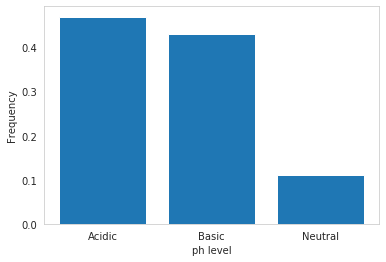

In [0]:
sizes = np.round((ph_level.values) / sum(ph_level.values), 2).tolist()
labels = ph_level.index.tolist()
plt.bar(x=labels, height=sizes)
plt.xlabel('ph level')
plt.ylabel('Frequency')
plt.show()

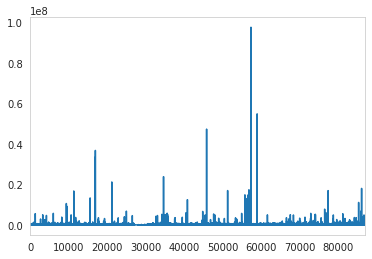

In [0]:
# Plotting counts of protein sequences as a function of
# Molecular weights.
data.structureMolecularWeight.plot()
plt.show()

In [0]:
# Relation between the densityMatthews and densityPercentSol
plt.figure(figsize=(9,5))
plt.scatter(x='densityMatthews', y='densityPercentSol', data=data, alpha=0.3)
plt.xlabel('densityMatthews', fontsize=15)
plt.ylabel('densityPercentSol', fontsize=15)
plt.show()

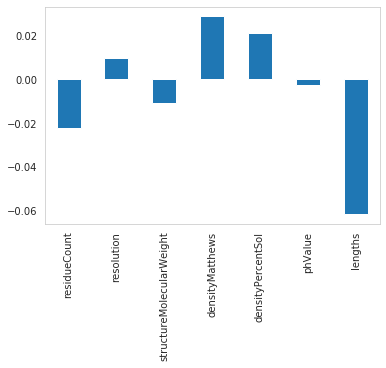

In [0]:
# Correlation of features to target. 
corr_with_class = data.corr()['label']
corr_with_class.drop('label').plot(kind='bar')

## Building a single train test model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, \
                classification_report, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [0]:
# Creating the dictionary of class and sequence counts
classes = data.classification.value_counts()
class_d = dict()
counting = 1

for cat, num in classes.items():
    if num > 1200: # Filtering the classes for classification purpose.
        class_d[cat] = counting
    counting += 1
len(class_d) 

15

In [0]:

data = data[data['classification'].isin(class_d.keys())]

In [0]:
# Separating the features and target. 
X = data.drop(['label', 'ph_level', 'structureId', 'classification', 'experimentalTechnique', 'sequence'], axis=1)
y = data['label']

#### Scaling with standard scaler

In [0]:
# Features are normalized with mean 0 and standard deviation 1
scaler = StandardScaler().fit(X)
X_norm = scaler.transform(X)
X_scaled = pd.DataFrame(X_norm, columns=X.columns)

#### Train-Test splitting

In [0]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_scaled,
                     y, test_size=0.3,
                     random_state=22)

Xt_train, Xt_test, yt_train, yt_test = \
    train_test_split(X, y,
                     test_size=0.3,
                     random_state=43)

### Random Forest Model

In [0]:
# Random forest model:
rf = RandomForestClassifier(n_estimators=100,
                            min_samples_leaf=3,
                            max_features=3, n_jobs=-1)

rf.fit(X_train, y_train)
predictions = rf.predict(X_test)
print(classification_report(y_test, prediction))
print('Accuracy: ',accuracy_score(y_test, predictions), '\n')
print('# of mis_classified: %d out of total: %d'
      %((y_test != predictions).sum(),
        X_test.shape[0]))
print('# of good_classified: ', (y_test == predictions).sum())

feat_importances = pd.Series(rf.feature_importances_,
                             index=X_train.columns)

Accuracy:  0.4026641883519207 

# of mis_classified: 9641 out of total: 16140
# of good_classified:  6499


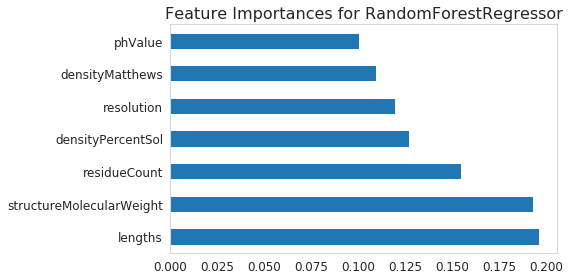

In [0]:
fig, ax = plt.subplots(figsize=(8, 4))
feat_importances.nlargest(15).plot(kind='barh', ax=ax, fontsize=12)
plt.title('Feature Importances for RandomForestRegressor', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(path_to_data, 'Random_forest_feature_Importance.pdf'))

In [0]:
# Tuning Hyperparameters:
param_grids = [{'n_estimators' : [20, 40, 100],
                'max_features' : [3, 4, 5]}]
kfold = KFold(n_splits=5, random_state=22, shuffle=True)
rfCv = GridSearchCV(rf, param_grids, cv=kfold, verbose=1)

rfCv.fit(X_train, y_train)

print('Train Accuracy:', rfCv.best_score_)
print('Best Paramters:', rfCv.best_params_)
print('Bset estimator:', rfCv.best_estimator_)

predictions = rfCv.predict(X_test)
print("Test Accuracy :",accuracy_score(y_test, predictions),'\n')

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, coding=False):
  '''This function plots the confusion matrix'''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=24)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)
    
    if coding:
      fmt = '.2f' if normalize else 'd'
      thresh = cm.max() / 2
      for i , j in itertools.product(range(cm.shape[0]),
                                     range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                   color='white' if cm[i, j] >= thresh else 'black')
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xlim(tick_marks[0]-0.5, tick_marks[len(classes)-1]+0.5)
    plt.ylim(tick_marks[0]-0.5, tick_marks[len(classes)-1]+0.5)

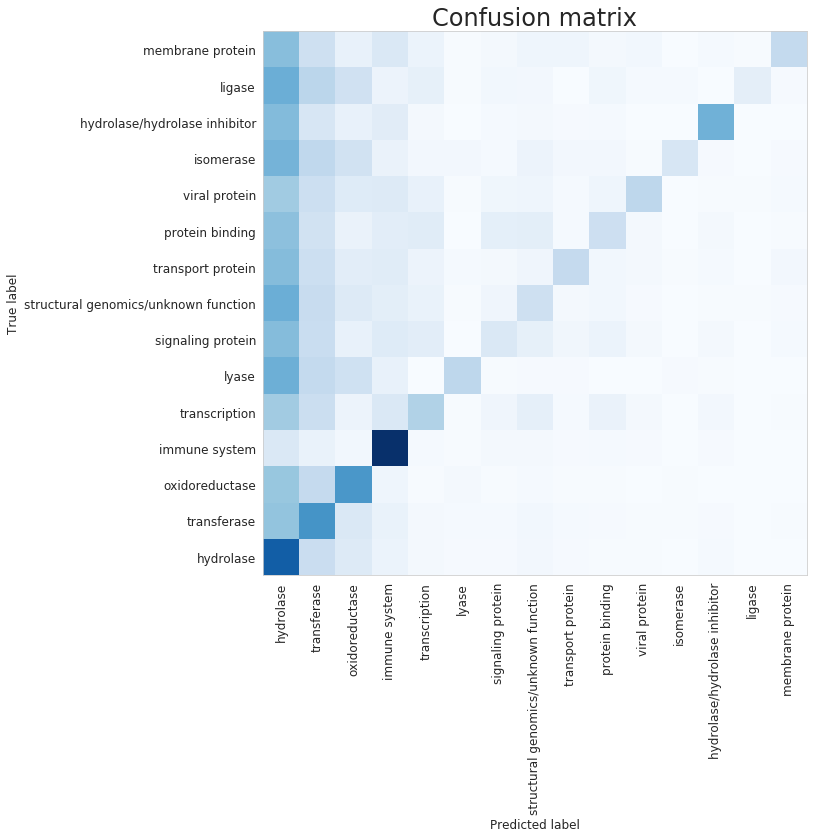

In [0]:
# Plotting the confusion matrix for classification:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, class_d)
plt.savefig(os.path.join(path_to_data, 'random_forest_confusion_matrix.pdf'))

### Decision Tree Model:

In [0]:
dtree = DecisionTreeClassifier(max_depth=100,
                               min_samples_leaf=1)
dtree.fit(X_train, y_train)

predictions = dtree.predict(X_test)
print(classification_report(y_test, predictions))
print('Accuracy: ', round(accuracy_score(y_test, predictions),2))

In [0]:
# Hyperparameter tuning: 
param_grid = [{'max_depth' : [5, 10, 100],
               'min_samples_leaf' : [1, 5, 10]}]
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
dtreeCv = GridSearchCV(dtree, param_grid, cv=kfold)
dtreeCv.fit(X_train, y_train)
print('Train Accuracy: ', dtreeCv.best_score_)
print('Best Parameters: ', dtreeCv.best_params_)
print('Best Estimators: ', dtreeCv.best_estimator_)

predictions = dtreeCv.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, predictions))

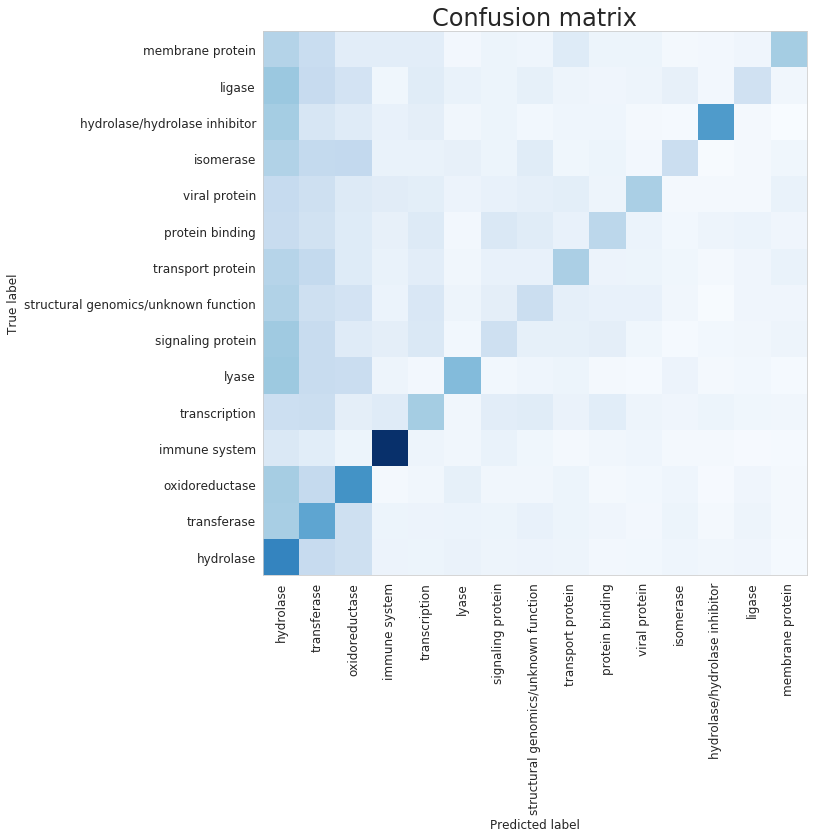

In [0]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, class_d)

### Gradient Boosting

In [0]:
gb = GradientBoostingClassifier(n_estimators=5,
                                learning_rate=0.01,
                                max_depth=3, verbose=2)
gb.fit(X_train, y_train)
predictions = gb.predict(X_test)
# print(classification_report(y_test, predictions))
print('Accuracy: ', accuracy_score(y_test, predictions))

In [0]:
# Hyperparameter Tuning:
param_grid = [{'learning_rate' : [0.001, 0.01, 0.1],
               'max_depth' : [2,3,4,5],
               'n_estimators': [20, 50, 100]}]
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
gbCv = RandomizedSearchCV(gb, param_grid, cv=kfold)
gbCv.fit(X_train, y_train)

print('Train Accuracy: ', gbCv.best_score_)
print(gbCv.best_params_)
print(gbCv.best_estimators_)

predictions = gbCv.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, predictions))

### Naive Bayes (Gaussian)

In [0]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
predictions = gnb.predict(X_test)
#print(classification_report(y_test, predictions))
print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.1214993804213135


In [0]:
# Validation:
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(gnb, X_train, y_train, cv=kfold)

print(scores)
print(scores.mean())

### Multinomial Naive Bayes [Does not work with negative inputs]

In [0]:
# Multinomial Naive Bayes does not work with negative
# inputs therefore we used the unscaled data for this 
# model

mnb = MultinomialNB()
mnb.fit(Xt_train, yt_train)
predictions = mnb.predict(Xt_test)

#print(classification_report(y_test, predictions))
print('Accuracy: ', accuracy_score(yt_test, predictions), '\n')

Accuracy:  0.0915737298636927 



In [0]:
# KFold cross validation:
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
scores = cross_val_score(mnb, Xt_train, yt_train, cv=kfold)

print(scores)
print('\n', 'Mean: ', scores.mean())

### Support Vector Machine

In [0]:
# The normalized 
Xv_train, Xv_test, yv_train, yv_test = \
    train_test_split(X_norm, y, test_size=0.3, random_state=44)

In [0]:
clf = LinearSVC(max_iter=20000, verbose=1)
clf.fit(Xv_train, yv_train)
predictions = clf.predict(Xv_test)
# print(classification_report(y_test, predictions))
print('Accuracy: ', accuracy_score(yv_test, predictions))

[LibLinear]Accuracy:  0.23048327137546468


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
param_grid = [{'C' : [1, 10],
               'dual' : [True, False]}]
kfold = KFold(n_splits=5, random_state=33, shuffle=True)
clfCv = GridSearchCV(clf, param_grid, cv=kfold)
clfCv.fit(Xv_train, yv_train)

print('Train Accuracy: ', clfCv.best_score_)
print('Best Parameters: ', clfCv.best_params_)
print('Best Estimators: ', clfCv.best_estimator_)

predictions = clfCv.predict(Xv_test)
print('Test Accuracy: ', accuracy_score(yv_test, predictions))

## K Nearest Neighbors

In [0]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
#print(classification_report(y_test, predictions))
print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.29510532837670383


In [0]:
param_grid = [{'n_neighbors' : [3, 5, 10],
               'weights' : ['uniform', 'distance']}]
kfold = KFold(n_splits=5, random_state=22, shuffle=True)
knnCv = GridSearchCV(knn, param_grid, cv=kfold)
knnCv.fit(X_train, y_train)

print('Train Accuracy: ', knnCv.best_score_)
print('Best Parameters: ', knnCv.best_params_)
print('Best Estimator: ', knnCv.best_estimator_)

predictions = knnCv.predict(X_test)
print('Test Accuracy: ', accuracy_score(y_test, predictions))

Train Accuracy:  0.31697588716858266
Best Parameters:  {'n_neighbors': 10, 'weights': 'distance'}
Best Estimator:  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')
Test Accuracy:  0.3224907063197026


## Accuracy: 
            Random Forest = 0.40
            Decision Tree = 0.3
       Gradient Boosting = 0.22
     Gaussian Naive Bayes = 0.12
     Multinomial Naive Bayes = 0.09
                      SVM = 0.15
                      KNN = 0.32
          
    

#### Therefore, Random Forest (RF) model performs better than other ML models with available samples and features. 